# Processing Sequences Using RNNs and CNNs

## Different Sequences of RNNs
- Sequence to Sequence (ex. Forecast time series such as home's daily power consumption)
- Sequence to Vector (ex. Feed the model a sequence of words corresponding to a movie review and output a sentiment score vector (0 to 1))
- Vector to Sequence (ex. The input could be an image or output of a CNN, then the output is the caption for that image)
- <b>Encoder</b>(Sequence to Vector) to <b>Decoder</b>(Vector to Sequence) (ex. Useful for language translating)

## Training RNNs

RNNs use a strategy called backpropagation through time(BPTT) to train. This is very similar to regular backpropagation but instead you unravel the RNN through time(which means that you let it go through a couple of times instead of other NN where you do one forward pass then backprop) then calculate the gradients and make step. <b>Note: Sometimes the loss function for RNNs only looks at certain outputs and not all of the outputs through the time.

### Forcasting a Time Series

In [1]:
import pandas as pd
from pathlib import Path
path = Path('/home/misha/Desktop/data/ml_book_data/CTA_-_Ridership_-_Daily_Boarding_Totals_20250126.csv')
df = pd.read_csv(path, parse_dates=['service_date'])
df.columns = ['date', 'day_type', 'bus', 'rail', 'total']

In [3]:
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis=1)
df = df.drop_duplicates()

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


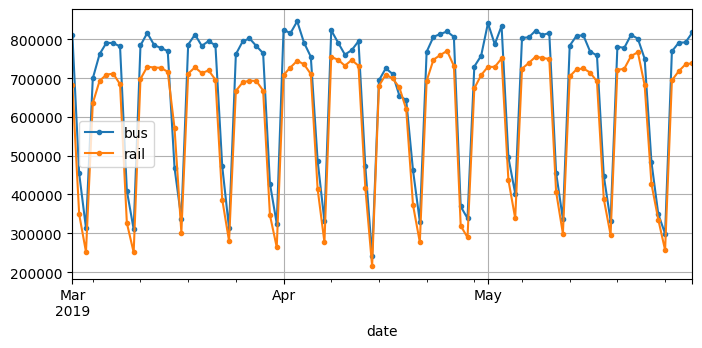

In [9]:
import matplotlib.pyplot as plt
df['2019-03': '2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

This is a time series: data with values at different time steps, usually at regular intervals. Since there are multiple values per time step, this is called a <b>multivariate time series</b>. If we only looked at the bus column, it would be a <b>univariate time series</b>, or a time series with a single value per time step.

<b>Naive forcasting</b> is when you just copy past values to make a forecast. This can be usful as a baseline and in some cases like this one where the data looks like it clearly repeats consitiantly, it can be difficult to beat.

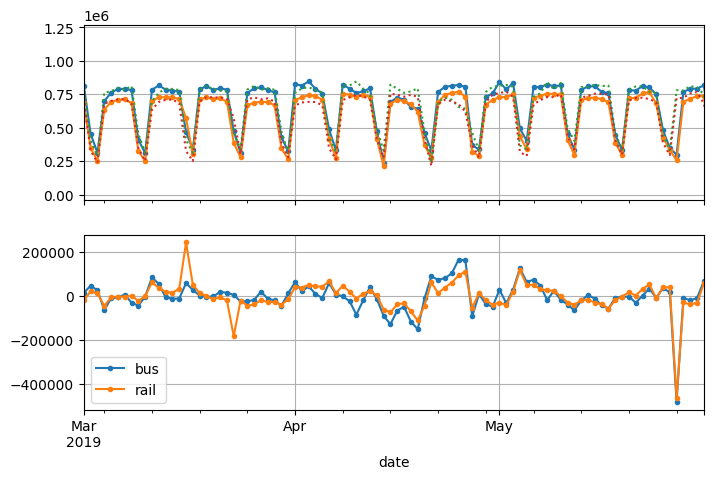

In [10]:
### Visualizing these naive forcasts by overlaying two time series lagged by a week
diff_7 = df[['bus', 'rail']].diff(7)['2019-03':'2019-05']

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,5))
df.plot(ax=axs[0], legend=False, marker='.')
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':')
diff_7.plot(ax=axs[1], grid=True, marker='.')
plt.show()

In [15]:
## Mean abs error (MAE)
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [16]:
## Mean abs percentage error (MAPE)
targets = df[['bus', 'rail']]['2019-03':'2019-05']
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

## The ARMA Model Family

The Autoregressive moving average(ARMA) model computes forecasts using a simple weighted sum of lagged values and corrects these forecasts by adding a moving average. This is a mathmatical model not a ML model

## Preparing the Data for ML Models

The goal of our ML model is to forecast tomorrow's ridership based on the ridership of the past 8 weeks of data(56 days). The input to the model will therefore be sequences containing 56 values. For each input sequence the model will output a single value: the forecast for time step t + 1. For the training data, we will use every 56-day window from the past as training data and the target for each window will be the value immediately following. 

In [21]:
import tensorflow as tf

2025-01-26 11:25:07.214557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 11:25:07.388741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737912307.440834    4747 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737912307.455292    4747 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 11:25:07.584281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [26]:
### Setting up training data using keras utils
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)

In [27]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [29]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1): ## Add drop_remainder=True to get rid of smaller windows
    for element in window_dataset:
        print(f"{element}", end=' ')
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-01-26 11:29:02.660153: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-01-26 11:29:02.670477: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The .window method returns a nested dataset which is like a list of lists. However we can't use this for our model so we must call flat_map() to convert a nested dataset into a flat dataset(one that contains tensors, not datasets).

In [30]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [31]:
## Helper function to make this easier
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [32]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Now we have the same output like from the utils function

Now lets split into training, val, and test dataset

In [33]:
rail_train = df['rail']['2016-01':'2018-12'] / 1e6
rail_valid = df['rail']['2019-01':'2019-05'] / 1e6
rail_test = df['rail']['2019-06':] / 1e6

In [34]:
seq_len = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_len:],
    sequence_length=seq_len,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_len:],
    sequence_length=seq_len,
    batch_size=32
)

### Forecasting with a Linear Model

In [35]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(seq_len,))
])
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                   callbacks=[early_stop])

/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step - loss: 0.1429 - mae: 0.5017

I0000 00:00:1737913242.526236    8338 service.cc:148] XLA service 0x73d7ac004d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737913242.526366    8338 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-26 11:40:42.541287: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737913242.575173    8338 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1737913242.679283    8338 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0494 - mae: 0.2487 - val_loss: 0.0084 - val_mae: 0.0955
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - mae: 0.0993 - val_loss: 0.0068 - val_mae: 0.0834
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0801 - val_loss: 0.0061 - val_mae: 0.0769
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - mae: 0.0820 - val_loss: 0.0064 - val_mae: 0.0815
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0764 - val_loss: 0.0057 - val_mae: 0.0745
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0816 - val_loss: 0.0056 - val_mae: 0.0743
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0737 - val_loss: 0.0049 - val_mae: 0.0670
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - mae: 0.0692 - val_loss: 0.0048 - val_mae: 0.0667
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mae: 0.

In [36]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - mae: 0.0392


37808.47787857056

### Forecasting with a Simple RNN

All recurrent layers in Keras expect 3D inputs of shape [batch_size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multivariate time series. 

In [38]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=(None, 1)),
    tf.keras.layers.Dense(1)
])
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
univar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = univar_model.fit(train_ds, validation_data=valid_ds, epochs=500,
                   callbacks=[early_stop])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0622 - mae: 0.2790 - val_loss: 0.0037 - val_mae: 0.0651
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mae: 0.0851 - val_loss: 0.0035 - val_mae: 0.0633
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0780 - val_loss: 0.0032 - val_mae: 0.0626
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0743 - val_loss: 0.0045 - val_mae: 0.0743
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mae: 0.0734 - val_loss: 0.0028 - val_mae: 0.0545
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mae: 0.0664 - val_loss: 0.0025 - val_mae: 0.0512
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mae: 0.0638 - val_loss: 0.0026 - val_mae: 0.0508
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0588 - val_loss: 0.0026 - val_mae: 0.0511
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.00

In [39]:
# extra code – evaluates the model
valid_loss, valid_mae = univar_model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - mae: 0.0284    


30871.04484438896

### Forecasting with a Deep RNN

In [40]:
## Deep RNNs are simple, just stack recurrent layers
deep_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
deep_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = deep_model.fit(train_ds, validation_data=valid_ds, epochs=500,
                   callbacks=[early_stop])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0601 - mae: 0.2637 - val_loss: 0.0048 - val_mae: 0.0702
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mae: 0.0805 - val_loss: 0.0048 - val_mae: 0.0716
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0631 - val_loss: 0.0027 - val_mae: 0.0466
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0591 - val_loss: 0.0041 - val_mae: 0.0674
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0664 - val_loss: 0.0024 - val_mae: 0.0412
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0651 - val_loss: 0.0031 - val_mae: 0.0491
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0558 - val_loss: 0.0023 - val_mae: 0.0448
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0563 - val_loss: 0.0045 - val_mae: 0.0780
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

In [41]:
# extra code – evaluates the model
valid_loss, valid_mae = deep_model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013 - mae: 0.0264    


28639.75800573826

### Forecasting Multivariate Time Series